In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from scipy.ndimage.filters import gaussian_filter1d

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sklearn.model_selection import train_test_split as tts
from tbats import BATS, TBATS

#### Authors: Mike Ovyan, Bogdan Nikitin, Lika Lomidze

## Introduction

In this tutorial we will focus on TBATS model for forecasting time series data. It includes Trigonometric Seasonal, Box-Cox Transformation, ARMA residuals, Trend and Seasonality. We will use the dataset to explore the models features, write down the theoretical representation of the model and its strengths and weaknesses. Further we will test and compare the model on the real-world data, and also construct confidence bands.

# TBATS

### Useful links

- Source code for TBATS library used in this tutorial: https://github.com/intive-DataScience/tbats
- Useful examples for different use-cases for the library: https://github.com/intive-DataScience/tbats/tree/master/examples
- More theory on BATS/TBATS: https://yintingchou.com/posts/bats-and-tbats-model/

## Dataset

The source of the dataset: https://www.kaggle.com/c/demand-forecasting-kernels-only/data


There is 5 years of daily store-item sales data for 50 different items at 10 different stores, we will focus on only one item. There are no holiday effects or store closures.

## Model

In [ ]:
df = pd.read_csv('train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)]
y = df['sales']

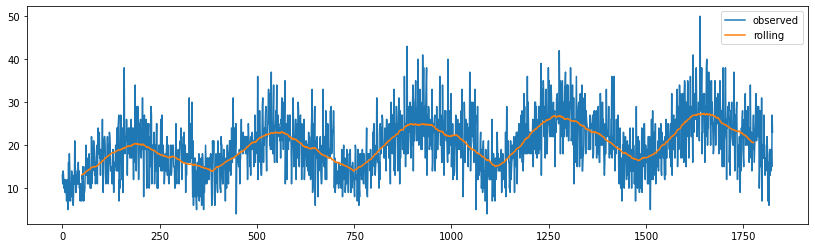

In [ ]:
plt.figure(figsize=(14, 4))
y_roll = y.rolling(100, center=True).mean().dropna()
plt.plot(y.index, y.values, label='observed')
plt.plot(y_roll.index, y_roll, label='rolling')
plt.legend()
plt.show()

We can see that our data has a clear **seasonal** pattern, with a positive **trend**.
The trend and seasonality both seems additive, since the amplitude and variance seems constant.

The legit modeling seems *not to use box-cox* transformation, use *2 seasonal components - 7, 365*
(based on what we've seen and the dataset nature), *trend with no damping*, and maybe catch
the remaining patterns using ARIMA on residuals if needed.

In [ ]:
estimator = TBATS(seasonal_periods=(7, 365), use_box_cox=False)
model = estimator.fit(y_train)
y_forecast = model.forecast(steps=365)

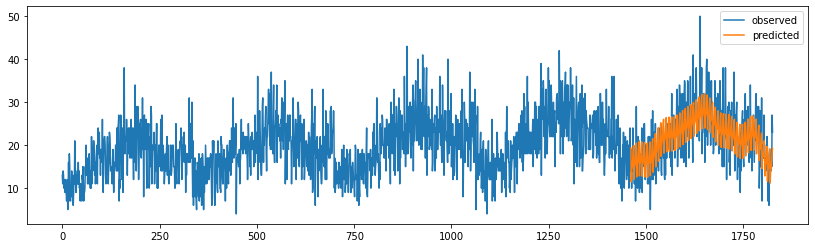

In [ ]:
plt.figure(figsize=(14, 4))
y_forecast_series = pd.Series(y_forecast, index=np.arange(len(y_train), len(y)))
plt.plot(y.index, y.values, label='observed')
plt.plot(y_forecast_series.index, y_forecast_series.values, label='predicted')
plt.legend()
plt.show()

In [ ]:
params = model.params
components = model.params.components

print(model.summary(), '\n')

print('1st seasonal smoothing parameters', params.gamma_1())  # one value for each season
print('2nd seasonal smoothing parameters', params.gamma_2())  # one value for each season

print('Trend and damping', components.use_trend, components.use_damped_trend)
print('Trend', params.beta)
print('Damping', params.phi)

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [3 6]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.019709
Seasonal Parameters (Gamma): [ 8.72841724e-09  1.67597743e-08 -1.77469439e-10  1.02000505e-08]
AR coefficients []
MA coefficients []
Seed vector [16.95548585 -2.63423986 -0.19616109  1.19379786 -0.73419187  1.77410447
  0.93199222 -4.68988095 -0.10562745 -1.07813312 -0.03917052 -0.44889777
 -0.07860096 -0.71468207 -0.92257625 -0.69651403  0.23721199  0.54218195
  0.72103407]

AIC 15019.068346 

1st seasonal smoothing parameters [ 8.72841724e-09 -1.77469439e-10]
2nd seasonal smoothing parameters [1.67597743e-08 1.02000505e-08]
Trend and damping False False
Trend None
Damping None


**Model:**

$ y_t = l_{t-1} + b_{t-1} + s_{t-7} + s_{t-365} + d_t$

$ l_t = l_{t-1} + b_{t-1} + 0.0197d_t $

$ b_t = b_{t-1} $

$ d_t = \epsilon_t $

**Seasonal part:**

For $m = 7$ and $m = 365$ separately: $ \omega_i = 2\pi j/m $, where $\omega$ is the power parameter.

For each $m$ the number of harmonics are $k_1 = 3$, $k_2 = 6$

***For m = 7:***
$s_t = \sum_{j=1}^{3} s_{j,t} $

$ s_{j,t} = s_{j,t-1} cos(\omega_i) + s^*_{j,t-1} sin(\omega_i) + 8.7e{-09} d_t $

$ s^*_{j,t} = -s_{j,t-1} sin(\omega_i) + s^*_{j,t-1} cos(\omega_i) + 1.6e{-08} d_t $

***For m = 365:***

$s_t = \sum_{j=1}^{6} s_{j,t} $

$ s_{j,t} = s_{j,t-1} cos(\omega_i) + s^*_{j,t-1} sin(\omega_i) + -1.7e{-10} d_t $

$ s^*_{j,t} = -s_{j,t-1} sin(\omega_i) + s^*_{j,t-1} cos(\omega_i) + 1.02e{-08} d_t $ 

### BATS
Strengths
- Box-cox transformation can deal with data with non-linearity and then somewhat makes the variance becomes constant.
- ARMA model on residuals can solve autocorrelation problem.
- No need to worry about initial values.
- Can get not only point prediction but also interval prediction.
- The performance is better than simple state space model.
Weaknesses
- Can not add explanotary variables.
- The periods of multiseaonality should be nested.
- For high frequency seasonality, the parameter will be very large.


### TBATS
Strengths:
- Can deal with data with non-integer seasonal period, non-nested periods and high frequency data.
- Can do multi-seasonality without increasing too much parameters.
- All the strengths that BATS has.
Weaknesses
- Can not add explanotary variables.
- The performance for long-term prediction is not very well.
- The computation cost is big if the data size is large.

## Comparison

To compare the performance of TBATS models with different seasonal periods and ETS model, we will forecast on the data containing daily sales of an item from a period of 5 years. And we will use the sliding window approach to compare forecasts of these models. 

### Sliding Window

*SKTime package does not support sliding window function for BATS models yet, so here is a manual implementation.*

In [ ]:
df = pd.read_csv('train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
y = df['sales']
X = np.arange(len(y))

In [ ]:
def moving_window(X, y, window_cnt=3):
    assert len(X) == len(y)
    plt.figure(figsize=(20, 14))
    window_size = len(X) // window_cnt
    for plot_num in range(window_cnt*3):
        cnt = plot_num % window_cnt
        plt.subplot(3, window_cnt, plot_num+1)
        start_, end_ = cnt * window_size, (cnt + 1) * window_size
        X_window, y_window = X[start_ : end_], y[start_ : end_]
        X_train, X_test, y_train, y_test  = tts(X_window, y_window, test_size=0.3, shuffle=False)
        if plot_num < 3:
            model = TBATS(seasonal_periods=(7, 365), use_box_cox=False).fit(y_train)
            y_forecast = model.forecast(steps=len(y_test))
            plt.title(f"Window {cnt+1} TBATS 7, 365")
        elif plot_num < 6:
            model = TBATS(seasonal_periods=(365,), use_box_cox=False).fit(y_train)
            y_forecast = model.forecast(steps=len(y_test))
            plt.title(f"Window {cnt+1} TBATS 365")
        elif plot_num < 9:
            model = AutoETS(error='mul', trend=None, seasonal='add', sp=182)
            model.fit(y_train.astype(np.float64))
            horizon = ForecastingHorizon(X_test, is_relative=False)
            y_forecast = model.predict(horizon)
            plt.title(f"Window {cnt+1} AutoETS MNA")

        plt.plot(X_window, y_window, label='True')
        plt.plot(X_test, y_forecast, label='Prediction')
        plt.legend()
    
    plt.show()


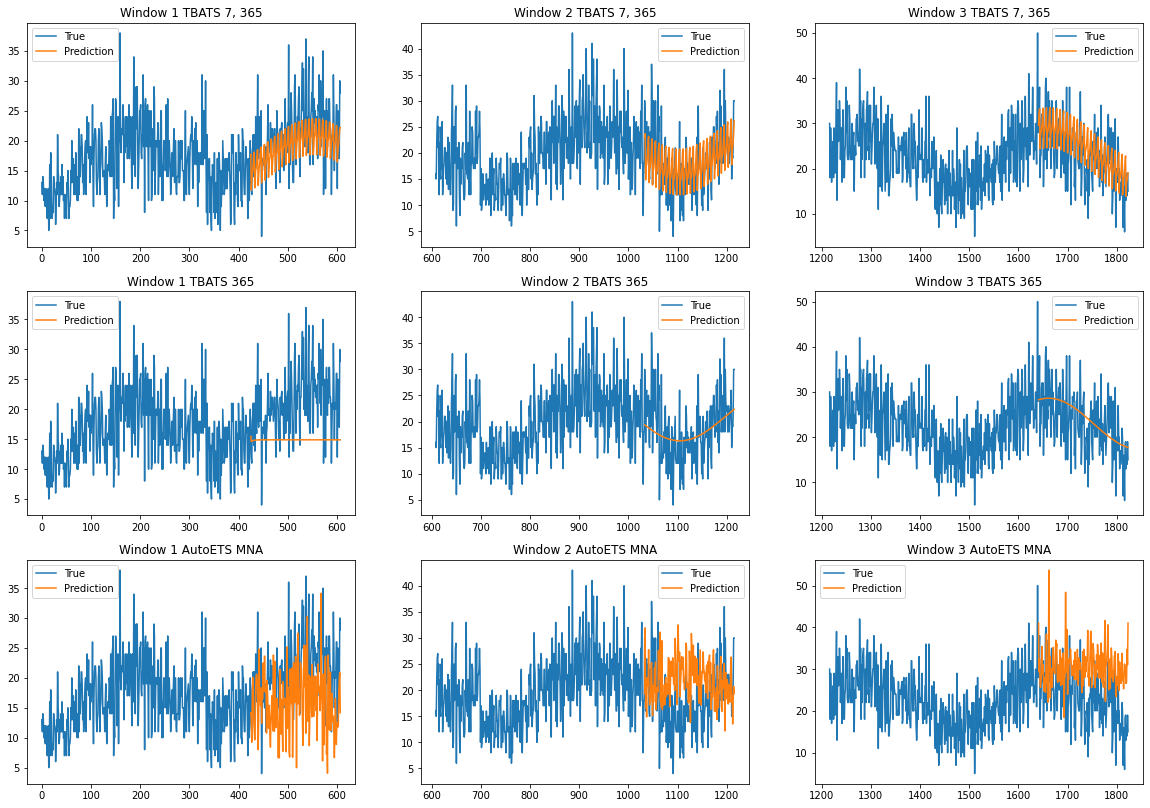

In [ ]:
moving_window(X=X, y=y, window_cnt=3)

It can be seen that the we have a multi-seasonal data, which has yearly and weekly seasonality, therefore TBATS (7, 365) has the best forecast. While others did not perform that well because TBATS (365) covers only yearly seasonal effect and AutoETS on the other hand is focused on weekly seasonality. As you can see, AutoETS wasn't used with an annual seasonality because it requires two full cycles of the season in the data (i.e. 365*2 days), however each window is only around 600, so we had to use 365/2 seasonality. This is also can be considered as a one of the features of TBATS as it can catch seasonality on a small dataset. Notice that we don't use the Box-Cox transformation because, firstly, our data seems to have a normal-distr shape. Secondly, the implementation of this transformation is done very poorly in this library, increase the training time twofold.

### Confidence intervals

Firstly, we will construct 95% confidence intervals for prediction on the last year.

In [ ]:
df = pd.read_csv('train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)]
y = df['sales']
y_train = y.iloc[:(len(y)-365)]
y_test = y.iloc[(len(y)-365):] # last year for testing

In [ ]:
estimator = TBATS(seasonal_periods=(7, 365), use_box_cox=False)
model = estimator.fit(y_train)
y_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

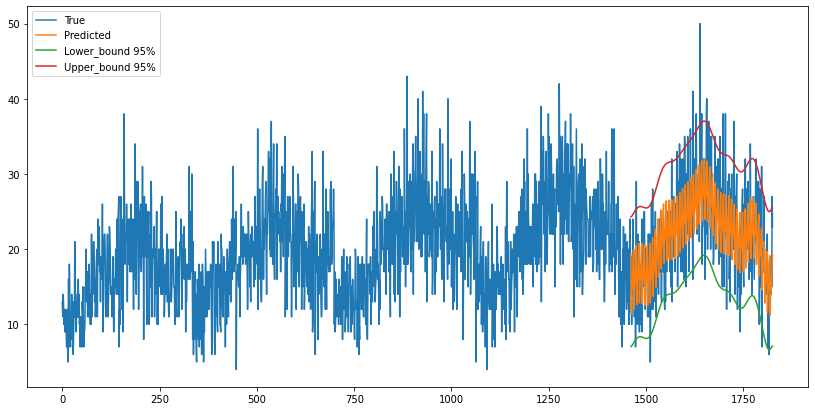

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(0, len(y)), y.values, label='True')
plt.plot(np.arange(len(y_to_train), len(y)), y_forecast, label='Predicted')

lb_smoothed = gaussian_filter1d(confidence_info['lower_bound'], sigma=5) 
ub_smoothed = gaussian_filter1d(confidence_info['upper_bound'], sigma=5) 
plt.plot(np.arange(len(y_to_train), len(y)), lb_smoothed, label='Lower_bound 95%')
plt.plot(np.arange(len(y_to_train), len(y)), ub_smoothed, label='Upper_bound 95%')
plt.legend()
plt.show()

We can see that despite the noisy data the cofidence interval is not wide, which means that TBATS model is suitable for forecasting on this dataset.

Overall, we can see many advantages of TBATS model over regular AutoETS on the given dataset. First of all, it requires less data to fit the seasonality (365 days is enough, while ETS needs at least two cycles).Secondly, it required less time to fit the model and to make a forecast. Also since T in TBATS stands for trigonometric seasonal, and our data has this kind of shape, we can see that TBATS produced a better fit, and hence a better prediction.